In [1]:
from autogluon.tabular import TabularPredictor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
# Load the city data.
# *                                                                                              *
# *You will have to download this yourself since you need to accept the Creative Commons license.*
# *                                                                                              *
# This is from https://simplemaps.com/data/us-cities
# The license is Creative Commons Attribution 4.0
# and requires that the above attribution message be maintained when you use this city data.
uscities_full = pd.read_csv('uscities.csv')
# Let's limit to the larger cities (top ~1000) and remove the long list of zip codes which makes printing the data difficult.
uscities_full = uscities_full.drop(columns=['zips'])
print(uscities_full.shape)
uscities_full.head()

(28338, 16)


,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,id
0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,10715,polygon,False,True,America/New_York,1,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,3276,polygon,False,True,America/Los_Angeles,1,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8373,-87.6862,8604203,4574,polygon,False,True,America/Chicago,1,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7839,-80.2102,6445545,5019,polygon,False,True,America/New_York,1,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7936,-96.7662,5743938,1526,polygon,False,True,America/Chicago,1,1840019440


In [4]:
uscities = uscities_full[['city_ascii', 'state_id', 'lat', 'lng']]



In [5]:
import time

add_sentence_embeddings_bert =True
pca_sentence_embeddings = True
pca_vectors=64
sentence_transformer_pretrained_model = 'average_word_embeddings_glove.6B.300d'

start_time = time.time()
# For bert you probably  need to
# pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.1+cpu.html
# first using pip3 list | grep torch to check your  torch version
#
if add_sentence_embeddings_bert:
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer(sentence_transformer_pretrained_model)

    embed_input = 'The city of ' + uscities['city_ascii'] + ' in the state of ' + uscities['state_id']
    sentence_embeddings = model.encode(embed_input)

    print('Raw embeddings are of shape {}'.format(sentence_embeddings.shape))
    if pca_sentence_embeddings:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=pca_vectors)
        pca.fit(sentence_embeddings)
        sentence_embeddings = pca.transform(sentence_embeddings)
        
    uscities = pd.concat([uscities, pd.DataFrame(data=sentence_embeddings, index=uscities.index.values)], axis=1)

print('Embeddings+PCA took {} seconds'.format(time.time() - start_time))
uscities.head()
    

2022-01-29 01:26:10.559481: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-29 01:26:10.559512: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Raw embeddings are of shape (28338, 300)
Embeddings+PCA took 12.24902892112732 seconds


,city_ascii,state_id,lat,lng,0,1,2,3,4,5,...,54,55,56,57,58,59,60,61,62,63
0,New York,NY,40.6943,-73.9249,0.849400,0.820013,1.254541,0.353357,0.413348,-0.441420,...,0.137036,-0.127866,0.075628,-0.021092,0.218757,-0.039213,0.000703,-0.189867,0.110580,-0.292075
1,Los Angeles,CA,34.1139,-118.4068,1.305180,-0.635572,0.122967,0.887420,-0.018160,0.369132,...,-0.106329,-0.183847,-0.155706,-0.097859,-0.385837,-0.008295,-0.130556,-0.014452,0.088158,-0.131901
2,Chicago,IL,41.8373,-87.6862,0.932880,-0.076211,-0.331474,-0.617400,1.546449,0.072458,...,-0.123613,-0.261697,-0.177045,-0.155087,-0.083728,-0.042255,-0.109548,-0.065185,0.043501,-0.145331
3,Miami,FL,25.7839,-80.2102,0.186373,-0.068975,0.157923,0.724348,0.113671,0.242770,...,0.108176,-0.101027,-0.124590,-0.223947,0.126153,-0.315618,-0.069937,-0.110061,-0.003273,0.163375
4,Dallas,TX,32.7936,-96.7662,-0.095743,-0.128843,-0.239901,1.512353,0.865598,1.117605,...,0.015942,-0.134882,-0.123620,-0.105853,0.029518,-0.117801,-0.051971,0.110129,0.020428,0.036708


In [6]:
# Split into parallel datasets, one to predict just latitude, one to predict just longitude.
# This is until AutoGluon does multiclass prediction.
uscities_lat = uscities.drop(columns=['lng'])
uscities_lng = uscities.drop(columns=['lat'])
uscities_lat.head()

,city_ascii,state_id,lat,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
0,New York,NY,40.6943,0.849400,0.820013,1.254541,0.353357,0.413348,-0.441420,0.668698,...,0.137036,-0.127866,0.075628,-0.021092,0.218757,-0.039213,0.000703,-0.189867,0.110580,-0.292075
1,Los Angeles,CA,34.1139,1.305180,-0.635572,0.122967,0.887420,-0.018160,0.369132,-0.358113,...,-0.106329,-0.183847,-0.155706,-0.097859,-0.385837,-0.008295,-0.130556,-0.014452,0.088158,-0.131901
2,Chicago,IL,41.8373,0.932880,-0.076211,-0.331474,-0.617400,1.546449,0.072458,0.347818,...,-0.123613,-0.261697,-0.177045,-0.155087,-0.083728,-0.042255,-0.109548,-0.065185,0.043501,-0.145331
3,Miami,FL,25.7839,0.186373,-0.068975,0.157923,0.724348,0.113671,0.242770,-0.320559,...,0.108176,-0.101027,-0.124590,-0.223947,0.126153,-0.315618,-0.069937,-0.110061,-0.003273,0.163375
4,Dallas,TX,32.7936,-0.095743,-0.128843,-0.239901,1.512353,0.865598,1.117605,0.355081,...,0.015942,-0.134882,-0.123620,-0.105853,0.029518,-0.117801,-0.051971,0.110129,0.020428,0.036708


In [10]:
# Standard train_test split.
# Let's only train on 50% of the data so we're left with some large, recognisable cities in the test set.
X_lat_train, X_lat_test, y_lat_train, y_lat_test = train_test_split(uscities_lat.drop(columns='lat'), uscities_lat['lat'], 
                                                                    test_size=0.5, random_state=42)
X_lng_train, X_lng_test, y_lng_train, y_lng_test = train_test_split(uscities_lng.drop(columns='lng'), uscities_lng['lng'], 
                                                                    test_size=0.5, random_state=42)

uscities_lat_train=pd.concat([X_lat_train, y_lat_train], axis=1)
uscities_lng_train=pd.concat([X_lng_train, y_lng_train], axis=1)
uscities_lat_test=pd.concat([X_lat_test, y_lat_test], axis=1)
uscities_lng_test=pd.concat([X_lng_test, y_lng_test], axis=1)

In [9]:
time_limit=600
predictor_lat = TabularPredictor(label='lat').fit(train_data=uscities_lat_train, time_limit=time_limit)
predictor_lng = TabularPredictor(label='lng').fit(train_data=uscities_lng_train, time_limit=time_limit)


No path specified. Models will be saved in: "AutogluonModels/ag-20220129_013003/"
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220129_013003/"
AutoGluon Version:  0.3.2b20220115
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    14169
Train Data Columns: 66
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (71.2728, 17.9608, 38.62721, 5.8819)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    30238.95 MB
	Train Data (Original)  Memory Usage: 5.4 MB (0.0% of available memory)
	Infer

Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    30140.29 MB
	Train Data (Original)  Memory Usage: 5.4 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
		Fitting CategoryFeatureGenerator...
			Fitting CategoryMemoryMinimizeFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('float', [])  : 64 | ['0', '1', '2', '3', '4', ...]
		('object', []) :  2 | ['city_ascii', 'state_id']
	Types of features in processed data (raw dtype, special dtypes):
		('category', []) :  2 | ['city_ascii', 'state_id']
		('float', [])    : 64 | ['0', '1', '2', '3', '4', ...]
	0.2s = Fit runtime
	66 fea

In [11]:
y_lat_pred = predictor_lat.predict(X_lat_test)
y_lng_pred = predictor_lng.predict(X_lng_test)
predictor_lat.leaderboard(uscities_lat_test, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-1.245469,-1.234881,10.233133,1.238428,63.387341,0.005576,0.000546,0.367566,2,True,11
1,LightGBMXT,-1.251783,-1.242867,0.094741,0.013764,1.891636,0.094741,0.013764,1.891636,1,True,3
2,LightGBM,-1.261832,-1.266227,0.057653,0.009812,1.772043,0.057653,0.009812,1.772043,1,True,4
3,LightGBMLarge,-1.286846,-1.326984,0.055721,0.009675,4.746930,0.055721,0.009675,4.746930,1,True,10
4,CatBoost,-1.328486,-1.302358,0.032300,0.011619,31.913301,0.032300,0.011619,31.913301,1,True,6
5,NeuralNetFastAI,-1.381752,-1.392380,0.235556,0.043123,16.242215,0.235556,0.043123,16.242215,1,True,8
6,XGBoost,-1.398584,-1.357015,0.314250,0.019365,11.126345,0.314250,0.019365,11.126345,1,True,9
7,KNeighborsUnif,-1.548828,-1.577200,4.750614,0.542459,0.037263,4.750614,0.542459,0.037263,1,True,1
8,KNeighborsDist,-1.551387,-1.557514,4.742443,0.597740,0.036972,4.742443,0.597740,0.036972,1,True,2
9,RandomForestMSE,-1.581443,-1.570076,0.489867,0.105124,45.339090,0.489867,0.105124,45.339090,1,True,5


In [12]:
predictor_lat.evaluate(uscities_lat_test, auxiliary_metrics=True)

Evaluation: root_mean_squared_error on test data: -1.2454694274960862
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -1.2454694274960862,
    "mean_squared_error": -1.5511940948274288,
    "mean_absolute_error": -0.939376659879914,
    "r2": 0.9548234144463169,
    "pearsonr": 0.9771676071826519,
    "median_absolute_error": -0.7486148315429659
}


{'root_mean_squared_error': -1.2454694274960862,
 'mean_squared_error': -1.5511940948274288,
 'mean_absolute_error': -0.939376659879914,
 'r2': 0.9548234144463169,
 'pearsonr': 0.9771676071826519,
 'median_absolute_error': -0.7486148315429659}

In [13]:
# Let's view the accuracy of ground truth vs predicted latitude
pd.concat([X_lat_test, y_lat_test, y_lat_pred, uscities_full['population']], axis=1, join='inner').sort_values(by='population',ascending=False).head(10)

,city_ascii,state_id,0,1,2,3,4,5,6,7,...,57,58,59,60,61,62,63,lat,lat,population
0,New York,NY,0.849400,0.820013,1.254541,0.353357,0.413348,-0.441420,0.668698,0.115499,...,-0.021092,0.218757,-0.039213,0.000703,-0.189867,0.110580,-0.292075,40.6943,41.207054,18713220
3,Miami,FL,0.186373,-0.068975,0.157923,0.724348,0.113671,0.242770,-0.320559,-0.076740,...,-0.223947,0.126153,-0.315618,-0.069937,-0.110061,-0.003273,0.163375,25.7839,27.517109,6445545
4,Dallas,TX,-0.095743,-0.128843,-0.239901,1.512353,0.865598,1.117605,0.355081,0.030327,...,-0.105853,0.029518,-0.117801,-0.051971,0.110129,0.020428,0.036708,32.7936,31.389645,5743938
5,Philadelphia,PA,0.520321,1.273114,0.477796,-0.439690,-0.092314,0.906057,-0.386530,-0.406017,...,-0.031802,-0.023187,-0.038904,0.019409,0.118909,0.095701,-0.048341,40.0077,40.655609,5649300
6,Houston,TX,-0.042703,-0.095697,-0.285839,1.544664,0.748846,1.230825,0.339976,0.070363,...,-0.152827,0.058530,-0.041013,-0.050483,0.123518,-0.124329,0.023911,29.7863,30.952545,5464251
7,Atlanta,GA,0.278315,0.303498,-0.212596,0.348062,-0.230402,0.897928,-0.468588,-0.022144,...,-0.017955,-0.011225,0.179394,-0.239874,0.010035,0.065235,-0.039829,33.7627,32.720287,5449398
8,Washington,DC,0.825931,0.455063,0.069215,0.311338,-0.015800,-0.006539,-0.066768,0.055101,...,0.002921,0.038997,-0.160167,-0.292773,-0.157063,0.296800,-0.099639,38.9047,40.535946,5379184
14,San Diego,CA,1.121415,-0.854579,0.077900,0.905865,0.028061,0.391101,-0.330059,-0.263661,...,0.376211,-0.029788,0.267439,-0.037980,-0.034104,0.028791,0.074124,32.8312,36.387295,3220118
17,Denver,CO,1.219574,0.224866,-0.248716,0.926486,0.175038,-0.127835,0.268608,-0.028729,...,-0.187490,-0.041097,-0.102760,-0.330291,0.187401,0.117626,0.058361,39.7621,39.562729,2876625
19,Queens,NY,0.319037,0.889196,1.247330,0.113027,0.170267,-0.553995,0.779104,0.120992,...,-0.187203,0.003898,-0.110616,0.011362,-0.139608,-0.063683,-0.094529,40.7498,41.291428,2230722


In [14]:
# Now let's plot the predicted location of some cities to understand what the model has done.
# First load the shapefile that contains the outline of US states.
from os.path import exists
import requests
import zipfile
import matplotlib.pyplot as plt
import geopandas
url = 'https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip'
filenamezip = url.split('/')[-1]
filenameshp = 'shp/' + filenamezip.replace('zip','shp')
if not exists(filenameshp):
    print('Downloading:'+url)
    r = requests.get(url)
    print('Writing:'+filenamezip)
    with open(filenamezip, 'wb') as f:
        f.write(r.content) 
    print('Unzipping to:'+filenameshp)
    with zipfile.ZipFile(filenamezip, 'r') as zip_ref:
        zip_ref.extractall('shp')
else:
    print('Already present:'+filenameshp)

Downloading:https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip
Writing:cb_2020_us_state_20m.zip
Unzipping to:shp/cb_2020_us_state_20m.shp


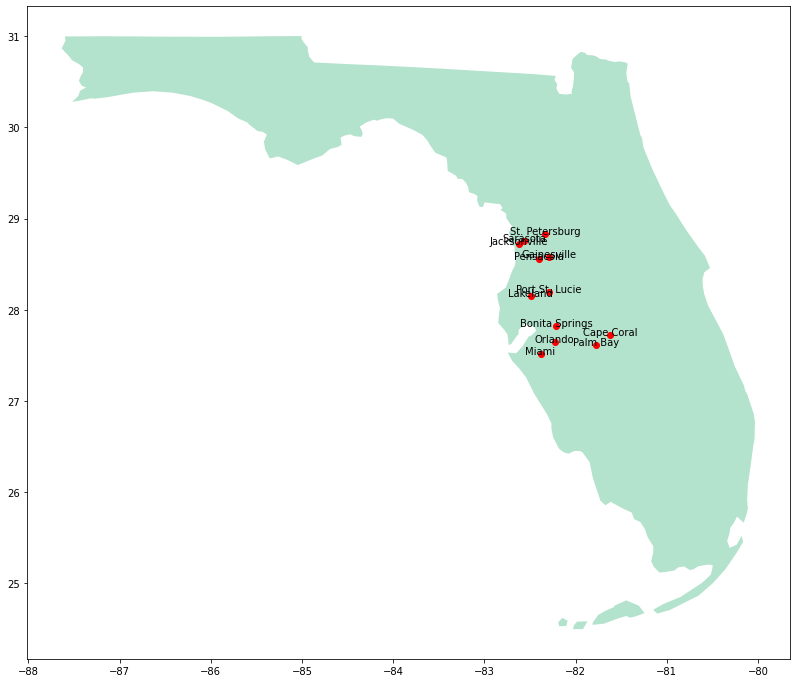

In [22]:
states = geopandas.read_file(filenameshp)
# which states shall we plot?
# statelist = ['FL']
statelist = ['CA', 'NV']
# Make a geoseries with the names and predicted locations of each city.
# The  cities are in X_{lat,lng}_test so  we can just choose one.
# Then we need the predicted lat and lng from the model results.
plotdf = pd.concat([X_lat_test, uscities_full['population'], y_lat_pred, y_lng_pred], axis=1, join='inner') # pull back uscities to get population
plotdf = plotdf[plotdf['state_id'].isin(statelist)]
plotdf = plotdf[plotdf['population']>200_000]
plotdf = plotdf.sort_values(by=['population'], ascending=False)

gdf = geopandas.GeoDataFrame(
    plotdf, geometry=geopandas.points_from_xy(plotdf['lng'], plotdf['lat']))

# We plot each city in the relevant states as a red dot, on the map of the relevant states. 
# Then we add annotations : the  nme of each city.
outlinemap = states[states['STUSPS'].isin(statelist)].plot(cmap='Pastel2', figsize=(14, 12))
gdf.plot(ax=outlinemap, color='red')
gdf.apply(lambda x: outlinemap.annotate(text=x['city_ascii'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

In [16]:
# For no sentence embeddings,we see that the model  puts cities roughly the centre of each state, because it
# has the state name to train from.
# The cities are not exactly on top of each other, because some city names are duplicated across the country, and this
# introduces some noise.

# When we add the sentence or word embeddings, you should get cities scattered slightly from the state centre, and with an approximately accurate layout.
